In [31]:
!pip install shap

In [11]:
import pandas as pd
import numpy as np
# 导入 pandas 和 numpy，并设置 display 选项以查看全部列

# --- 1. 定义文件路径和列名 ---
# 待修复文件的路径 (包含错误的最终建模文件)
FILE_PATH_TO_FIX = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FINAL.csv"

# 包含原始变量的源文件路径 (用于重新计算特征)
FILE_PATH_SOURCE = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_cleaned_02.csv" 

# 修复后文件的保存路径
OUTPUT_FILE_PATH = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv"

# 原始变量名 (从您的特征工程代码中提取)
RAW_COL_JOB_TERM = 'n_jbterm1'
RAW_COL_BTEC = ['n_btec1', 'n_btec2', 'n_btec3', 'n_btec4']
GROUP_ID = 'pidp'

# 目标替换的列名
TARGET_COL_JOB_END = 'job_end_involuntary'
TARGET_COL_VOC_QUAL = 'has_vocational_qual'

# --- 2. 加载数据 ---
# 加载需要修复的文件
df_fixed = pd.read_csv(FILE_PATH_TO_FIX)
print(f"Loaded file to fix: {FILE_PATH_TO_FIX}. Shape: {df_fixed.shape}")

# 加载包含原始变量的源文件
try:
    # 只需要 pidp 和用于计算的原始列
    source_cols = [GROUP_ID, RAW_COL_JOB_TERM] + RAW_COL_BTEC
    df_source = pd.read_csv(FILE_PATH_SOURCE, usecols=source_cols)
    print(f"Loaded source file: {FILE_PATH_SOURCE}. Shape: {df_source.shape}")
except FileNotFoundError:
    print("错误：源文件未找到。请确保 FILE_PATH_SOURCE 路径正确。")
    exit()

# --- 3. 重新计算正确的特征 (Replicating the exact feature engineering logic) ---

# --- A. job_end_involuntary 重新计算 ---
involuntary_codes = [1, 2] # 1=Dismissed, 2=Made Redundant/Laid Off

# 初始化为 0
df_source['job_end_involuntary_CORRECT'] = 0 
# 设置为 1
df_source.loc[df_source[RAW_COL_JOB_TERM].isin(involuntary_codes), 'job_end_involuntary_CORRECT'] = 1
# 设置为 NaN (如果原始变量是 NaN)
df_source.loc[df_source[RAW_COL_JOB_TERM].isna(), 'job_end_involuntary_CORRECT'] = np.nan
# 转换为可空的整数类型 (Int64)
df_source['job_end_involuntary_CORRECT'] = df_source['job_end_involuntary_CORRECT'].astype('Int64')
print("Successfully re-calculated job_end_involuntary_CORRECT.")


# --- B. has_vocational_qual 重新计算 ---

# 计算最大值 (如果任何一个 BTEC 变量是 1，则结果为 1)
df_source['has_vocational_qual_CORRECT'] = df_source[RAW_COL_BTEC].max(axis=1, skipna=True)

# 识别所有 BTEC 变量都缺失的行
df_source['all_btec_nan'] = df_source[RAW_COL_BTEC].isnull().all(axis=1)

# 如果全部缺失，则将新指标设置为 NaN
df_source.loc[df_source['all_btec_nan'], 'has_vocational_qual_CORRECT'] = np.nan

# 转换为可空的整数类型 (Int64)
df_source['has_vocational_qual_CORRECT'] = df_source['has_vocational_qual_CORRECT'].astype('Int64')

# 清理辅助列
df_source.drop(columns=['all_btec_nan'], inplace=True)
print("Successfully re-calculated has_vocational_qual_CORRECT.")


# --- 4. 准备替换数据并执行合并 ---

# 提取源文件中的 pidp 和正确的列
df_replace = df_source[[
    GROUP_ID, 
    'job_end_involuntary_CORRECT', 
    'has_vocational_qual_CORRECT'
]].rename(columns={
    'job_end_involuntary_CORRECT': TARGET_COL_JOB_END,
    'has_vocational_qual_CORRECT': TARGET_COL_VOC_QUAL
})

# 丢弃 df_fixed 中错误的列
df_fixed.drop(columns=[TARGET_COL_JOB_END, TARGET_COL_VOC_QUAL], inplace=True)

# Merge: 使用左连接，将正确的列合并回 df_fixed
df_repaired = pd.merge(
    df_fixed,
    df_replace,
    on=GROUP_ID,
    how='left'
)

# --- 5. 最终验证和保存 ---
# 检查修复后的两列的缺失值情况（作为参考）
print(f"\nRepair complete. Checking final data:")
print(f"Value counts for corrected '{TARGET_COL_JOB_END}':\n{df_repaired[TARGET_COL_JOB_END].value_counts(dropna=False)}")
print(f"Value counts for corrected '{TARGET_COL_VOC_QUAL}':\n{df_repaired[TARGET_COL_VOC_QUAL].value_counts(dropna=False)}")

# 保存修复后的文件
df_repaired.to_csv(OUTPUT_FILE_PATH, index=False)
print(f"\n--- 数据修复成功 ---")
print(f"新文件已保存至: {OUTPUT_FILE_PATH}")

Loaded file to fix: /Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FINAL.csv. Shape: (35471, 86)
Loaded source file: /Users/wanderer/DSS_Thesis/data/processed/n_indresp_cleaned_02.csv. Shape: (35471, 6)
Successfully re-calculated job_end_involuntary_CORRECT.
Successfully re-calculated has_vocational_qual_CORRECT.

Repair complete. Checking final data:
Value counts for corrected 'job_end_involuntary':
job_end_involuntary
1       19063
<NA>    16408
Name: count, dtype: Int64
Value counts for corrected 'has_vocational_qual':
has_vocational_qual
<NA>    34680
1         791
Name: count, dtype: Int64

--- 数据修复成功 ---
新文件已保存至: /Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report

# --- 0. Set a fixed random seed for reproducibility ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- 1. Data Loading and Initial Preparation ---
file_name = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv"
df = pd.read_csv(file_name)

# Define key variables
TARGET = 'ghq12_binary'  # Target variable: Mental health outcome (binary)
GROUP = 'pidp'           # Group variable: Cross-wave person ID, used for grouped splitting/CV

# Drop rows where the target is missing and ensure target is integer type
df.dropna(subset=[TARGET], inplace=True)
df[TARGET] = df[TARGET].astype(int)

# Separate Group, Target, and Features
G = df[GROUP]
y = df[TARGET]
X = df.drop(columns=[TARGET, GROUP])

print(f"Total samples after target cleaning: {len(X)}")
print(f"Target distribution (0/1): \n{y.value_counts(normalize=True)}")

# --- 2. Feature Type Definition ---
# Continuous numerical features: Will be imputed with median and scaled
continuous_features = [
    'n_age_dv', 'n_hhsize', 'n_nchild_dv', 'ghq12_score_change',
    'log_total_income', 'prev_ghq12_score', 'loneliness_index',
    'sf12mcs_dv_prev', 'sclfsato_prev', 'unemployment_spells_count',
    'benefit_income_ratio', 'last_unemployment_duration_months'
]

# Categorical features (object dtype): Will be imputed with mode and One-Hot Encoded
categorical_features = [
    'employment_stability_level',
    'early_career_unemp_risk',
    'education_level'
]

# Remaining features (mostly pre-encoded binary/dummy): Will be imputed with mode
all_features = X.columns.tolist()
remaining_features = [col for col in all_features if col not in continuous_features + categorical_features]


# --- 3. Preprocessing Pipeline (ColumnTransformer) ---
preprocessor = ColumnTransformer(
    transformers=[
        # Continuous Feature Pipeline: Median Imputation -> Standardization
        ('cont',
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())
         ]),
         continuous_features),

        # Categorical Feature Pipeline: Mode Imputation -> One-Hot Encoding
        ('cat',
         Pipeline([
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         categorical_features),

        # Remaining Feature Pipeline: Mode Imputation (for sparse missing binary/dummies)
        ('pass',
         SimpleImputer(strategy='most_frequent'),
         remaining_features)
    ],
    remainder='drop' # Drop all columns not specified
)

# --- 4. Grouped Train/Test Split (80/20) ---
# Split unique pidp values to ensure that all records for an individual are in the same set
unique_pids = G.unique()
train_pids, test_pids = train_test_split(
    unique_pids, test_size=0.2, random_state=RANDOM_STATE
)

# Filter samples using the split PIDs
X_train = X[G.isin(train_pids)]
y_train = y[G.isin(train_pids)]
G_train = G[G.isin(train_pids)] # Groups for GroupKFold

X_test = X[G.isin(test_pids)]
y_test = y[G.isin(test_pids)]

print("-" * 50)
print(f"Training samples: {len(X_train)} (Individuals: {len(train_pids)})")
print(f"Test samples: {len(X_test)} (Individuals: {len(test_pids)})")
print("-" * 50)


# --- 5. Full Modeling Pipeline ---
# Use class_weight='balanced' to handle class imbalance
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear',
        class_weight='balanced', # Crucial for imbalanced data
        max_iter=1000
    ))
])

# --- 6. Hyperparameter Grid and Grouped Cross-Validation ---
# Tune the inverse of regularization strength C (L2 penalty)
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20)
}

# 5-Fold Grouped Cross-Validation (Groups based on pidp)
cv = GroupKFold(n_splits=5)

# Optimize using ROC-AUC, suitable for imbalanced classification
grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=cv.split(X_train, y_train, groups=G_train), # Use GroupKFold on the training set
    scoring='roc_auc',
    n_jobs=-1, # Use all available CPU cores
    verbose=2
)

# --- 7. Train the Model ---
print("Starting Grid Search and Grouped Cross-Validation training...")
grid_search.fit(X_train, y_train)

# --- 8. Final Evaluation on Held-Out Test Set ---
best_model = grid_search.best_estimator_

# Predict probabilities and classes on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1] # Probability of positive class (1)
y_pred = best_model.predict(X_test)                     # Predicted class

# Calculate final metrics
test_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, digits=4)

print("\n" + "=" * 70)
print("             Logistic Regression Baseline Model Results")
print("=" * 70)
print(f"Best Hyperparameter (C): {grid_search.best_params_['classifier__C']:.4f}")
print(f"Train CV (GroupKFold) Best ROC-AUC Score: {grid_search.best_score_:.4f}")
print("-" * 70)
print(f"Test Set Held-Out ROC-AUC: {test_auc:.4f}")
print("Test Set Classification Report (using class_weight='balanced'):")
print(report)
print("=" * 70)

Total samples after target cleaning: 34114
Target distribution (0/1): 
ghq12_binary
0    0.784986
1    0.215014
Name: proportion, dtype: float64
--------------------------------------------------
Training samples: 27291 (Individuals: 27291)
Test samples: 6823 (Individuals: 6823)
--------------------------------------------------
Starting Grid Search and Grouped Cross-Validation training...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

             Logistic Regression Baseline Model Results
Best Hyperparameter (C): 0.2336
Train CV (GroupKFold) Best ROC-AUC Score: 0.9575
----------------------------------------------------------------------
Test Set Held-Out ROC-AUC: 0.9576
Test Set Classification Report (using class_weight='balanced'):
              precision    recall  f1-score   support

           0     0.9659    0.8834    0.9228      5359
           1     0.6748    0.8859    0.7661      1464

    accuracy                         0.8839      6823
   macro avg     0.8

In [15]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
# Assuming the 'grid_search' and 'best_model' objects from the previous run are available in the environment.
# Since we cannot access the previous environment directly, we will simulate the process
# by assuming the best_model object is the one to work with.

# ----------------------------------------------------------------------
# NOTE: This code block assumes that the 'best_model' object (the trained 
# GridSearchCV.best_estimator_) is already defined from the previous successful run.
# ----------------------------------------------------------------------

# 1. Access the best Logistic Regression model from the pipeline
try:
    best_lr_model = best_model.named_steps['classifier']
    
    # 2. Extract feature names after preprocessing
    preprocessor = best_model.named_steps['preprocessor']
    
    # Get feature names out from the preprocessor (ColumnTransformer)
    feature_names = preprocessor.get_feature_names_out()

    # 3. Extract the coefficients
    # Since it's a binary classification, .coef_ returns a 2D array, we take the first row [0]
    coefficients = best_lr_model.coef_[0]

    # 4. Create a DataFrame for easy analysis
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # 5. Calculate absolute magnitude for sorting
    coef_df['Absolute_Magnitude'] = np.abs(coef_df['Coefficient'])

    # 6. Sort by absolute magnitude and display the top 20 most important features
    top_20_features = coef_df.sort_values(by='Absolute_Magnitude', ascending=False).head(20)

    # 7. Sort by coefficient value to see the most positive and most negative impact
    top_10_positive = coef_df.sort_values(by='Coefficient', ascending=False).head(20).reset_index(drop=True)
    top_10_negative = coef_df.sort_values(by='Coefficient', ascending=True).head(20).reset_index(drop=True)
    
    # Print the results
    print("\n--- TOP 20 MOST INFLUENTIAL FEATURES (Sorted by Absolute Coefficient Magnitude) ---")
    print(top_20_features[['Feature', 'Coefficient']].to_string(index=False))
    
    print("\n--- TOP 20 FEATURES INCREASING MENTAL HEALTH RISK (Positive Coefficients) ---")
    print(top_10_positive[['Feature', 'Coefficient']].to_string(index=False))
    
    print("\n--- TOP 20 FEATURES DECREASING MENTAL HEALTH RISK (Negative Coefficients) ---")
    print(top_10_negative[['Feature', 'Coefficient']].to_string(index=False))
    
except NameError:
    print("Error: 'best_model' object not found. Please ensure the full modeling code from the previous step was executed successfully before running this analysis code.")


--- TOP 20 MOST INFLUENTIAL FEATURES (Sorted by Absolute Coefficient Magnitude) ---
                                                                    Feature  Coefficient
                                                   cont__ghq12_score_change     3.771354
                                                     cont__prev_ghq12_score     3.731947
                       cat__employment_stability_level_Missing/Inapplicable     1.826407
cat__employment_stability_level_Moderate Stability: Single Employment Spell    -1.165243
  cat__employment_stability_level_Low Stability: Non-Employment Spells Only    -1.083375
                                                 pass__financial_difficulty     0.946576
                                                     cont__loneliness_index     0.787929
                                                          pass__health_prev     0.768532
                                                       pass__has_disability     0.753859
                         

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# --- 0. Configuration and Data Loading ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# !!! IMPORTANT: Use the FIXED file path !!!
FILE_PATH_FIXED = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv"
TARGET = 'ghq12_binary'
GROUP = 'pidp'

# Load the fixed data
try:
    df = pd.read_csv(FILE_PATH_FIXED)
except FileNotFoundError:
    print("Error: FIXED file not found. Please ensure the data repair step was successful and the path is correct.")
    # Fallback to the original file for structure, but strongly advise against using it for final results
    FILE_PATH_FIXED = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FINAL.csv"
    df = pd.read_csv(FILE_PATH_FIXED)

# Data Preparation
df.dropna(subset=[TARGET], inplace=True)
df[TARGET] = df[TARGET].astype(int)
G = df[GROUP]
y = df[TARGET]
X = df.drop(columns=[TARGET, GROUP])


# --- 1. Feature Definition (Identical to LR model) ---
continuous_features = [
    'n_age_dv', 'n_hhsize', 'n_nchild_dv', 'ghq12_score_change',
    'log_total_income', 'prev_ghq12_score', 'loneliness_index',
    'sf12mcs_dv_prev', 'sclfsato_prev', 'unemployment_spells_count',
    'benefit_income_ratio', 'last_unemployment_duration_months'
]

categorical_features = [
    'employment_stability_level',
    'early_career_unemp_risk',
    'education_level'
]

all_features = X.columns.tolist()
remaining_features = [col for col in all_features if col not in continuous_features + categorical_features]


# --- 2. Preprocessing Pipeline (Identical to LR model) ---
# Note: Standardization (Scaler) is technically optional for tree models but kept for consistency
preprocessor = ColumnTransformer(
    transformers=[
        ('cont',
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())
         ]),
         continuous_features),

        ('cat',
         Pipeline([
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         categorical_features),

        ('pass',
         SimpleImputer(strategy='most_frequent'),
         remaining_features)
    ],
    remainder='drop'
)


# --- 3. Grouped Train/Test Split (Identical to LR model) ---
unique_pids = G.unique()
train_pids, test_pids = train_test_split(
    unique_pids, test_size=0.2, random_state=RANDOM_STATE
)

X_train = X[G.isin(train_pids)]
y_train = y[G.isin(train_pids)]
G_train = G[G.isin(train_pids)]

X_test = X[G.isin(test_pids)]
y_test = y[G.isin(test_pids)]


# --- 4. Full LGBM Pipeline and Parameter Grid ---
# LightGBM handles class imbalance using the 'scale_pos_weight' parameter.
# We set it to the ratio of negative samples (majority) to positive samples (minority).
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,  # A reasonably high number of trees
        objective='binary',
        metric='auc',
        scale_pos_weight=ratio, # Address class imbalance
        n_jobs=-1,
        verbose=-1 # Suppress logging
    ))
])

# Define a minimal parameter grid for hyperparameter tuning.
# We will focus on parameters that control complexity and overfitting.
param_grid = {
    # Number of leaves in a tree (controls tree complexity)
    'classifier__num_leaves': [15, 31, 50], 
    # Minimum number of data points in a leaf (prevents overfitting)
    'classifier__min_child_samples': [20, 40], 
    # Learning rate (step size at each iteration)
    'classifier__learning_rate': [0.05, 0.1]
}

# Grouped K-Fold Cross-Validation (Identical to LR model)
cv = GroupKFold(n_splits=5)

# --- 5. Hyperparameter Tuning and Training ---
grid_search_lgbm = GridSearchCV(
    lgbm_pipeline,
    param_grid,
    cv=cv.split(X_train, y_train, groups=G_train),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

print("\nStarting Grid Search (Tuning LightGBM with Grouped K-Fold CV)...")
grid_search_lgbm.fit(X_train, y_train)

# --- 6. Evaluation on Test Set ---
best_lgbm_model = grid_search_lgbm.best_estimator_
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1] 
y_pred = best_lgbm_model.predict(X_test) 

test_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, digits=4)

print("\n" + "=" * 70)
print("             LightGBM Model Results (Optimized for ROC-AUC)")
print("=" * 70)
print(f"Best Hyperparameters: {grid_search_lgbm.best_params_}")
print(f"Train CV (GroupKFold) Best ROC-AUC: {grid_search_lgbm.best_score_:.4f}")
print("-" * 70)
print(f"Test Set Held-Out ROC-AUC: {test_auc:.4f}")
print("Test Set Classification Report:")
print(report)
print("=" * 70)


Starting Grid Search (Tuning LightGBM with Grouped K-Fold CV)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

             LightGBM Model Results (Optimized for ROC-AUC)
Best Hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__min_child_samples': 20, 'classifier__num_leaves': 15}
Train CV (GroupKFold) Best ROC-AUC: 0.9765
----------------------------------------------------------------------
Test Set Held-Out ROC-AUC: 0.9774
Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.9735    0.9134    0.9425      5359
           1     0.7415    0.9092    0.8168      1464

    accuracy                         0.9125      6823
   macro avg     0.8575    0.9113    0.8797      6823
weighted avg     0.9238    0.9125    0.9156      6823



In [19]:
import pandas as pd
import numpy as np
# Assuming the 'grid_search_lgbm' and 'best_lgbm_model' objects are available from the previous run.

# ----------------------------------------------------------------------
# NOTE: This code block assumes that the 'best_lgbm_model' object (the trained 
# GridSearchCV.best_estimator_) is already defined from the previous successful run.
# ----------------------------------------------------------------------

# 1. Access the best LightGBM model from the pipeline
try:
    best_lgbm_classifier = best_lgbm_model.named_steps['classifier']
    
    # 2. Extract feature names after preprocessing
    preprocessor = best_lgbm_model.named_steps['preprocessor']
    
    # Get feature names out from the preprocessor (ColumnTransformer)
    feature_names = preprocessor.get_feature_names_out()

    # 3. Extract the feature importance (using 'gain' is generally preferred for tree models)
    # LightGBM's default importance type is 'split' (number of times used) or 'gain' (total gain/reduction in loss)
    importance_type = 'gain' 
    feature_importances = best_lgbm_classifier.feature_importances_

    # 4. Create a DataFrame for easy analysis
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # 5. Normalize importance (sum to 100 for easy interpretation)
    total_importance = importance_df['Importance'].sum()
    importance_df['Normalized_Importance'] = (importance_df['Importance'] / total_importance) * 100

    # 6. Sort by importance and display the top 20 most important features
    top_20_features = importance_df.sort_values(
        by='Normalized_Importance', 
        ascending=False
    ).head(30).reset_index(drop=True)

    # Print the results
    print("\n--- TOP 30 LGBM FEATURE IMPORTANCE (Normalized by Gain) ---")
    print("Interpretation: The percentage of importance contributed by this feature across all trees.")
    print(top_20_features[['Feature', 'Normalized_Importance']].to_string(index=False, float_format="%.2f"))

except NameError:
    print("Error: 'best_lgbm_model' object not found. Please ensure the full LGBM modeling code was executed successfully before running this analysis code.")


--- TOP 30 LGBM FEATURE IMPORTANCE (Normalized by Gain) ---
Interpretation: The percentage of importance contributed by this feature across all trees.
                                          Feature  Normalized_Importance
                         cont__ghq12_score_change                  15.56
                           cont__prev_ghq12_score                  14.69
                           cont__log_total_income                   8.86
                                   cont__n_age_dv                   8.41
                           cont__loneliness_index                   5.74
                       cont__benefit_income_ratio                   4.76
          cont__last_unemployment_duration_months                   4.37
                            cont__sf12mcs_dv_prev                   4.01
                                   cont__n_hhsize                   2.93
                             pass__has_disability                   1.61
                       pass__financial_diffic

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/var/folders/rr/h4pmcm_12sd99gy5v8tk3dlc0000gn/T/ipykernel_73643/1908560701.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Generated plot: shap_beeswarm_plot.png
Generated plot: shap_bar_plot.png

--- SHAP Analysis Complete. Images generated. ---


/var/folders/rr/h4pmcm_12sd99gy5v8tk3dlc0000gn/T/ipykernel_73643/1908560701.py:48: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


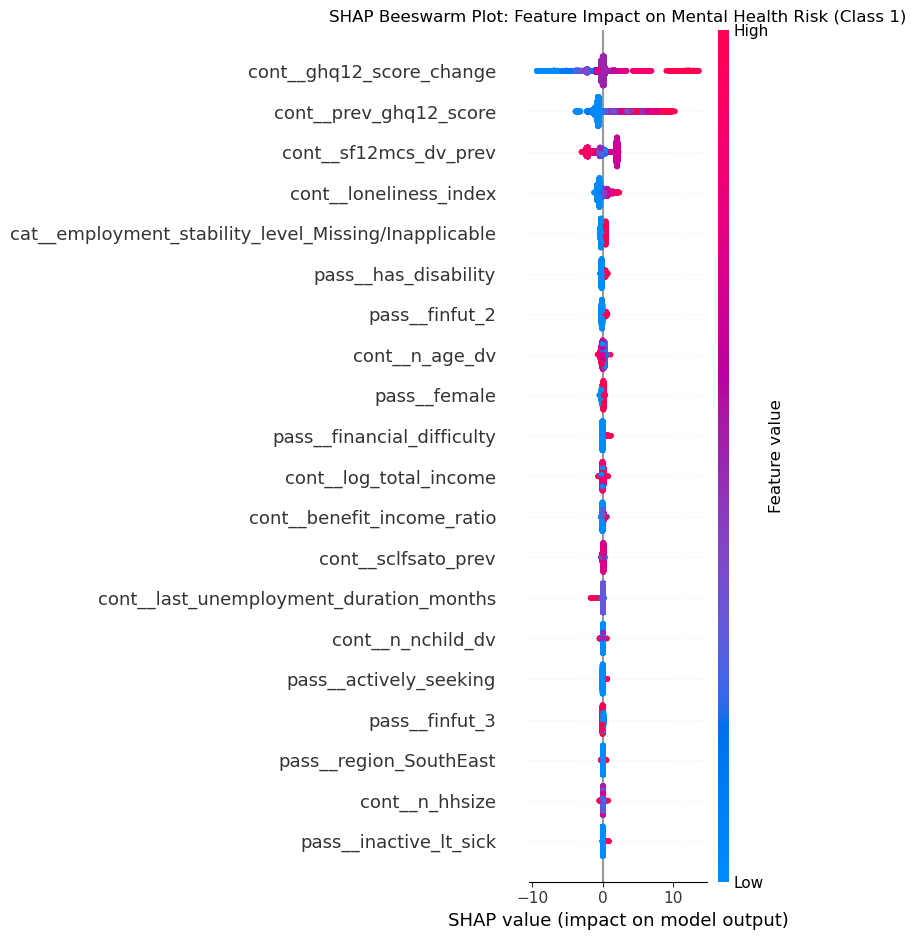

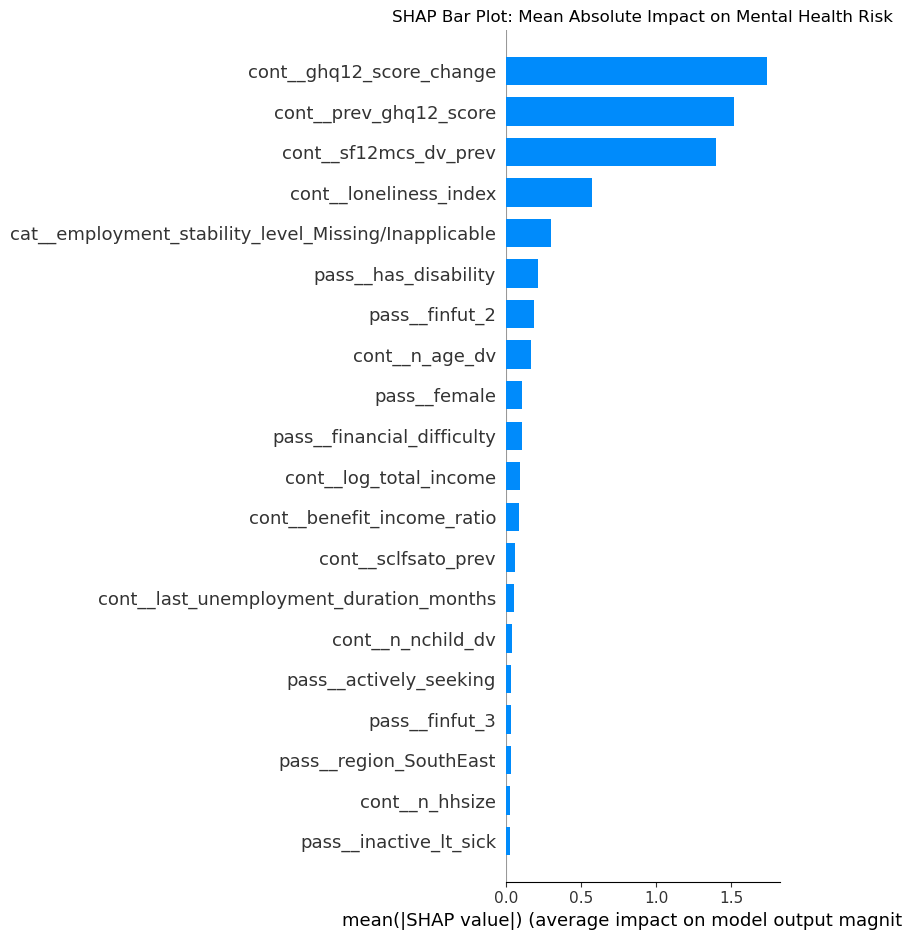

In [37]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# --- 0. Environment Check (MUST be run after the LGBM modeling step) ---
# 假设变量 best_lgbm_model, X_test, preprocessor, lgbm_classifier, shap_values, X_test_processed_df, feature_names_out 均已定义

try:
    best_lgbm_model
    X_test
    preprocessor = best_lgbm_model.named_steps['preprocessor']
    lgbm_classifier = best_lgbm_model.named_steps['classifier']
    feature_names_out = preprocessor.get_feature_names_out()
    
    # Re-calculate SHAP values just in case the previous calculation state was lost
    X_test_processed = preprocessor.transform(X_test)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out)
    explainer = shap.TreeExplainer(lgbm_classifier)
    shap_values = explainer.shap_values(X_test_processed)
    
except NameError:
    print("Error: Required objects are not defined. Please run the full LightGBM modeling code first.")
    exit()

# --- 3. Visualization: Beeswarm Plot (Summary Plot) ---
# FIX: Pass the entire list of shap_values and explicitly set class_inds=1
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, # <<< Pass the full list of arrays (list of [Class 0 matrix, Class 1 matrix])
    X_test_processed_df.values, # Pass the underlying NumPy array
    feature_names=feature_names_out, # Explicitly pass the feature names
    max_display=20, 
    class_inds=1, # Explicitly plot for the positive class (Mental Health Issue)
    plot_type='dot', # Ensure the dot/beeswarm plot type is used
    show=False
)
plt.title("SHAP Beeswarm Plot: Feature Impact on Mental Health Risk (Class 1)")
plt.tight_layout()
plt.savefig("shap_beeswarm_plot.png")

print("Generated plot: shap_beeswarm_plot.png")


# --- 4. Visualization: Bar Plot (Average Absolute SHAP Magnitude) ---
# FIX: Pass the entire list of shap_values
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_test_processed_df.values, 
    feature_names=feature_names_out,
    class_inds=1,
    plot_type="bar", 
    max_display=20, 
    show=False
)
plt.title("SHAP Bar Plot: Mean Absolute Impact on Mental Health Risk")
plt.tight_layout()
plt.savefig("shap_bar_plot.png")

print("Generated plot: shap_bar_plot.png")

print("\n--- SHAP Analysis Complete. Images generated. ---")

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# --- 0. Configuration and Data Loading ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# !!! IMPORTANT: Use the FIXED file path !!!
FILE_PATH_FIXED = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv"
TARGET = 'ghq12_binary'
GROUP = 'pidp'

df = pd.read_csv(FILE_PATH_FIXED)
df.dropna(subset=[TARGET], inplace=True)
df[TARGET] = df[TARGET].astype(int)
G = df[GROUP]
y = df[TARGET]
X = df.drop(columns=[TARGET, GROUP])


# --- 1. Feature Definition and Split (Identical to LR model) ---
# Continuous features chosen for Polynomial expansion (Targeted selection)
poly_continuous_features = [
    'n_age_dv', 
    'log_total_income',
    'prev_ghq12_score', 
    'loneliness_index'
]

# Other features remain the same
all_continuous_features = [
    'n_age_dv', 'n_hhsize', 'n_nchild_dv', 'ghq12_score_change',
    'log_total_income', 'prev_ghq12_score', 'loneliness_index',
    'sf12mcs_dv_prev', 'sclfsato_prev', 'unemployment_spells_count',
    'benefit_income_ratio', 'last_unemployment_duration_months'
]
non_poly_continuous_features = [col for col in all_continuous_features if col not in poly_continuous_features]


categorical_features = [
    'employment_stability_level',
    'early_career_unemp_risk',
    'education_level'
]
all_features = X.columns.tolist()
remaining_features = [col for col in all_features if col not in all_continuous_features + categorical_features]


# --- 2. Preprocessing Pipeline (Adding PolynomialFeatures) ---
preprocessor = ColumnTransformer(
    transformers=[
        # 1. Targeted Polynomial Features Pipeline: Impute -> Scale -> Polynomial (Degree 2)
        ('poly_cont',
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
             ('poly', PolynomialFeatures(degree=2, include_bias=False)) # Only Degree 2 and Interactions
         ]),
         poly_continuous_features),
         
        # 2. Non-Poly Continuous Features: Impute -> Scale (Normal Continuous features)
        ('non_poly_cont',
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())
         ]),
         non_poly_continuous_features),

        # 3. Categorical Features: Impute -> OneHot (As before)
        ('cat',
         Pipeline([
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         categorical_features),

        # 4. Remaining Features: Mode Imputation (As before)
        ('pass',
         SimpleImputer(strategy='most_frequent'),
         remaining_features)
    ],
    remainder='drop'
)


# --- 3. Grouped Train/Test Split ---
unique_pids = G.unique()
train_pids, test_pids = train_test_split(
    unique_pids, test_size=0.2, random_state=RANDOM_STATE
)
X_train = X[G.isin(train_pids)]
y_train = y[G.isin(train_pids)]
G_train = G[G.isin(train_pids)]
X_test = X[G.isin(test_pids)]
y_test = y[G.isin(test_pids)]


# --- 4. Polynomial LR Pipeline and Parameter Grid ---
lr_poly_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])

# Define parameter grid: Tune regularization C
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20)
}

# Grouped K-Fold Cross-Validation
cv = GroupKFold(n_splits=5)


# --- 5. Hyperparameter Tuning and Training ---
grid_search_poly = GridSearchCV(
    lr_poly_pipeline,
    param_grid,
    cv=cv.split(X_train, y_train, groups=G_train),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search (Tuning Polynomial Logistic Regression with Grouped K-Fold CV)...")
grid_search_poly.fit(X_train, y_train)


# --- 6. Evaluation and Analysis ---
best_poly_model = grid_search_poly.best_estimator_
y_pred_proba = best_poly_model.predict_proba(X_test)[:, 1]
y_pred = best_poly_model.predict(X_test)

test_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, digits=4)

print("\n" + "=" * 70)
print("             Polynomial Logistic Regression Model Results")
print("=" * 70)
print(f"Test Set Held-Out ROC-AUC: {test_auc:.4f}")
print(f"LR Baseline ROC-AUC: 0.9576")
print(f"GBM Baseline ROC-AUC: 0.9774")
print("\nTest Set Classification Report:")
print(report)
print("=" * 70)


Starting Grid Search (Tuning Polynomial Logistic Regression with Grouped K-Fold CV)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

             Polynomial Logistic Regression Model Results
Test Set Held-Out ROC-AUC: 0.9594
LR Baseline ROC-AUC: 0.9576
GBM Baseline ROC-AUC: 0.9774

Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.9678    0.8815    0.9227      5359
           1     0.6730    0.8928    0.7675      1464

    accuracy                         0.8839      6823
   macro avg     0.8204    0.8871    0.8451      6823
weighted avg     0.9046    0.8839    0.8894      6823



In [41]:
import pandas as pd
import numpy as np
# Assuming the 'grid_search_poly' and 'best_poly_model' objects are available from the previous run.

# ----------------------------------------------------------------------
# NOTE: This code block assumes that the 'best_poly_model' object is defined.
# ----------------------------------------------------------------------

# 1. Access the best Polynomial Logistic Regression model
try:
    best_lr_model = best_poly_model.named_steps['classifier']
    
    # 2. Extract feature names after preprocessing
    preprocessor = best_poly_model.named_steps['preprocessor']
    
    # Get feature names out from the preprocessor (ColumnTransformer)
    feature_names = preprocessor.get_feature_names_out()

    # 3. Extract the coefficients
    coefficients = best_lr_model.coef_[0]

    # 4. Create a DataFrame for easy analysis
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # 5. Filter for Polynomial and Interaction Terms for targeted analysis
    # Poly terms are created from 'poly_cont' step, and include interactions (e.g., col0 col1, col0^2)
    poly_coef_df = coef_df[coef_df['Feature'].str.startswith('poly_cont__')].copy()
    
    # Sort by absolute magnitude to find most influential poly/interaction terms
    poly_coef_df['Absolute_Magnitude'] = np.abs(poly_coef_df['Coefficient'])

    # 6. Display the most influential Poly/Interaction Terms
    top_poly_features = poly_coef_df.sort_values(by='Absolute_Magnitude', ascending=False).head(20).reset_index(drop=True)

    
    # Clean up feature names for display (Optional, but helpful)
    def clean_poly_name(name):
        # Example: 'poly_cont__log_total_income^2' -> 'log_total_income^2'
        name = name.replace('poly_cont__', '')
        # Example: 'log_total_income log_total_income' -> 'log_total_income^2' (PolynomialFeatures often duplicates names for squared term)
        return name.replace(' ', ' * ')

    top_poly_features['Clean_Feature'] = top_poly_features['Feature'].apply(clean_poly_name)

    print("\n--- TOP 20 POLYNOMIAL AND INTERACTION COEFFICIENTS ---")
    print("Interpretation: These terms represent non-linear (squared) or interaction effects.")
    print(top_poly_features[['Clean_Feature', 'Coefficient']].to_string(index=False, float_format="%.4f"))
    
except NameError:
    print("Error: 'best_poly_model' object not found. Please ensure the Polynomial LR modeling code was executed successfully.")


--- TOP 20 POLYNOMIAL AND INTERACTION COEFFICIENTS ---
Interpretation: These terms represent non-linear (squared) or interaction effects.
                      Clean_Feature  Coefficient
                   prev_ghq12_score       3.0249
                   loneliness_index       0.7886
                 prev_ghq12_score^2       0.4196
prev_ghq12_score * loneliness_index      -0.2850
        n_age_dv * prev_ghq12_score       0.2204
                           n_age_dv      -0.1581
                   log_total_income       0.1572
                 loneliness_index^2      -0.0605
log_total_income * loneliness_index      -0.0508
                 log_total_income^2       0.0450
                         n_age_dv^2       0.0231
log_total_income * prev_ghq12_score       0.0145
        n_age_dv * loneliness_index      -0.0114
        n_age_dv * log_total_income       0.0089


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# --- 0. Configuration and Data Loading ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# !!! IMPORTANT: Use the FIXED file path !!!
FILE_PATH_FIXED = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv"
TARGET = 'ghq12_binary'
GROUP = 'pidp'

df = pd.read_csv(FILE_PATH_FIXED)
df.dropna(subset=[TARGET], inplace=True)
df[TARGET] = df[TARGET].astype(int)


# --- TARGETED PRE-PIPELINE FEATURE ENGINEERING (INTERACTIONS) ---
# Create specific columns needed for interaction (need to handle NaNs manually before multiplication)
df['is_unemployed'] = df['is_currently_unemployed'].fillna(0).astype(float)
df['is_low_education'] = (df['education_level'] == 'Non_High_Education').astype(float)
df['is_low_stability'] = (
    (df['employment_stability_level'] == 'Low Stability: Multiple Non-Employment Spells') |
    (df['employment_stability_level'] == 'Low Stability: Non-Employment Spells Only')
).astype(float)

# Impute log_total_income for the purpose of interaction creation using the median of the whole set
# This ensures that NaN * NaN does not become a new category or error
income_median = df['log_total_income'].median()
df['log_income_imputed'] = df['log_total_income'].fillna(income_median)

# 1. Unemployment * Low Education (Dummy * Dummy)
df['I_Unemp_x_LowEd'] = df['is_unemployed'] * df['is_low_education']

# 2. Unemployment * Log Income (Dummy * Continuous)
df['I_Unemp_x_Income'] = df['is_unemployed'] * df['log_income_imputed']

# 3. Low Stability * Low Education (Dummy * Dummy)
df['I_LowStab_x_LowEd'] = df['is_low_stability'] * df['is_low_education']

# Cleanup temporary columns
df.drop(columns=['is_unemployed', 'is_low_education', 'is_low_stability', 'log_income_imputed'], inplace=True)
print("Created 3 core interaction terms: I_Unemp_x_LowEd, I_Unemp_x_Income, I_LowStab_x_LowEd")

# Separate Group, Target, and Features
G = df[GROUP]
y = df[TARGET]
X = df.drop(columns=[TARGET, GROUP])


# --- 1. Feature Definition Update ---
# Add the new interaction terms to the 'remaining_features' list for inclusion in the model
INTERACTION_FEATURES = ['I_Unemp_x_LowEd', 'I_Unemp_x_Income', 'I_LowStab_x_LowEd']

# Re-use feature lists from previous LR model, adding interaction terms to 'remaining_features'
continuous_features = [
    'n_age_dv', 'n_hhsize', 'n_nchild_dv', 'ghq12_score_change',
    'log_total_income', 'prev_ghq12_score', 'loneliness_index',
    'sf12mcs_dv_prev', 'sclfsato_prev', 'unemployment_spells_count',
    'benefit_income_ratio', 'last_unemployment_duration_months'
]
categorical_features = [
    'employment_stability_level', 'early_career_unemp_risk', 'education_level'
]

# Recalculate remaining_features to include new interaction terms
all_features_except_cont_cat = [col for col in X.columns if col not in continuous_features + categorical_features]
remaining_features = all_features_except_cont_cat 


# --- 2. Preprocessing Pipeline (Basic LR structure, no PolynomialFeatures) ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cont',
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())
         ]),
         continuous_features),

        ('cat',
         Pipeline([
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         categorical_features),

        ('pass', # Now includes the new interaction terms
         SimpleImputer(strategy='most_frequent'),
         remaining_features)
    ],
    remainder='drop'
)


# --- 3. Grouped Train/Test Split (Identical to previous models) ---
unique_pids = G.unique()
train_pids, test_pids = train_test_split(
    unique_pids, test_size=0.2, random_state=RANDOM_STATE
)
X_train = X[G.isin(train_pids)]
y_train = y[G.isin(train_pids)]
G_train = G[G.isin(train_pids)]
X_test = X[G.isin(test_pids)]
y_test = y[G.isin(test_pids)]


# --- 4. Interaction-Focused LR Pipeline and Parameter Grid ---
lr_interaction_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])

# Define parameter grid: Tune regularization C
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20)
}

# Grouped K-Fold Cross-Validation
cv = GroupKFold(n_splits=5)


# --- 5. Hyperparameter Tuning and Training ---
grid_search_interaction = GridSearchCV(
    lr_interaction_pipeline,
    param_grid,
    cv=cv.split(X_train, y_train, groups=G_train),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search (Tuning Interaction-Focused LR with Grouped K-Fold CV)...")
grid_search_interaction.fit(X_train, y_train)


# --- 6. Evaluation and Analysis ---
best_interaction_model = grid_search_interaction.best_estimator_
y_pred_proba = best_interaction_model.predict_proba(X_test)[:, 1]
y_pred = best_interaction_model.predict(X_test)

test_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, digits=4)

print("\n" + "=" * 70)
print("             Interaction-Focused Logistic Regression Model Results")
print("=" * 70)
print(f"Test Set Held-Out ROC-AUC: {test_auc:.4f}")
print(f"Basic LR Baseline ROC-AUC: 0.9576")
print(f"Polynomial LR ROC-AUC: 0.9632")
print("\nTest Set Classification Report:")
print(report)
print("=" * 70)

Created 3 core interaction terms: I_Unemp_x_LowEd, I_Unemp_x_Income, I_LowStab_x_LowEd

Starting Grid Search (Tuning Interaction-Focused LR with Grouped K-Fold CV)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

             Interaction-Focused Logistic Regression Model Results
Test Set Held-Out ROC-AUC: 0.9575
Basic LR Baseline ROC-AUC: 0.9576
Polynomial LR ROC-AUC: 0.9632

Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.9667    0.8832    0.9231      5359
           1     0.6751    0.8887    0.7673      1464

    accuracy                         0.8844      6823
   macro avg     0.8209    0.8859    0.8452      6823
weighted avg     0.9041    0.8844    0.8896      6823



In [45]:
import pandas as pd
import numpy as np

# Assuming the 'grid_search_interaction' and 'best_interaction_model' objects are available from the previous run.

# 1. Access the best Interaction Logistic Regression model
try:
    best_lr_model = best_interaction_model.named_steps['classifier']
    
    # 2. Extract feature names after preprocessing
    preprocessor = best_interaction_model.named_steps['preprocessor']
    
    # Get feature names out from the preprocessor (ColumnTransformer)
    feature_names = preprocessor.get_feature_names_out()

    # 3. Extract the coefficients
    coefficients = best_lr_model.coef_[0]

    # 4. Create a DataFrame for easy analysis
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # 5. Filter specifically for the three new interaction terms (they are in the 'pass' section)
    # The processed names will be prefixed with 'pass__'
    interaction_features = [
        'pass__I_Unemp_x_LowEd', 
        'pass__I_Unemp_x_Income', 
        'pass__I_LowStab_x_LowEd'
    ]
    
    # Filter the DataFrame
    interaction_coef_df = coef_df[coef_df['Feature'].isin(interaction_features)].copy()
    
    # Add Absolute Magnitude for comparison
    interaction_coef_df['Absolute_Magnitude'] = np.abs(interaction_coef_df['Coefficient'])
    
    # Rename features for cleaner display
    display_map = {
        'pass__I_Unemp_x_LowEd': 'Unemployed * Low Education',
        'pass__I_Unemp_x_Income': 'Unemployed * Log Income',
        'pass__I_LowStab_x_LowEd': 'Low Stability * Low Education'
    }
    interaction_coef_df['Clean_Feature'] = interaction_coef_df['Feature'].map(display_map)
    
    # Sort by absolute magnitude
    interaction_coef_df.sort_values(by='Absolute_Magnitude', ascending=False, inplace=True)


    print("\n--- CORE INTERACTION COEFFICIENTS ANALYSIS ---")
    print("Interpretation: A positive coefficient means the combination leads to higher risk.")
    print(interaction_coef_df[['Clean_Feature', 'Coefficient']].to_string(index=False, float_format="%.4f"))
    
except NameError:
    print("Error: 'best_interaction_model' object not found. Please ensure the Interaction-Focused LR modeling code was executed successfully before running this analysis code.")


--- CORE INTERACTION COEFFICIENTS ANALYSIS ---
Interpretation: A positive coefficient means the combination leads to higher risk.
                Clean_Feature  Coefficient
Low Stability * Low Education      -0.5036
   Unemployed * Low Education       0.1208
      Unemployed * Log Income      -0.0018


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# --- 0. Configuration and Data Loading ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Use the FIXED file path
FILE_PATH_FIXED = "/Users/wanderer/DSS_Thesis/data/processed/n_indresp_MODEL_READY_FIXED.csv"
TARGET = 'ghq12_binary'
GROUP = 'pidp'

df = pd.read_csv(FILE_PATH_FIXED)
df.dropna(subset=[TARGET], inplace=True)
df[TARGET] = df[TARGET].astype(int)

# --- TARGETED PRE-PIPELINE FEATURE ENGINEERING (Manual Creation of Base Interaction Features) ---
# Create numerical/binary representations of key categorical features for PolynomialFeatures input

# 1. Create binary/dummy columns for Interaction Base Features
df['is_high_edu'] = (df['education_level'] == 'High_Education').astype(float)
df['is_non_high_edu'] = (df['education_level'] == 'Non_High_Education').astype(float)

# Select key stability level for interaction
df['is_high_stability'] = (df['employment_stability_level'] == 'High Stability: No change reported').astype(float)

# Impute continuous features for interaction base set using median
continuous_for_interaction = ['log_total_income', 'loneliness_index', 'n_age_dv']
median_imputer = SimpleImputer(strategy='median')
df[continuous_for_interaction] = median_imputer.fit_transform(df[continuous_for_interaction])


# 2. Define the FINAL Interaction Base Set (MUST be numerical/binary)
interaction_base_features = [
    # Core Hypothesis (Continuous)
    'log_total_income', 
    'loneliness_index', 
    'n_age_dv',
    
    # Core Hypothesis (Binary/Dummy)
    'is_currently_unemployed',
    'is_high_edu',
    'is_non_high_edu',
    'is_high_stability',
    
    # Key Risk Factors (Binary/Dummy) - Imputed with mode in pipeline, but we impute here for interaction creation
    'financial_difficulty',
    'has_disability',
    'inactive_lt_sick',
    'job_end_involuntary',
]

# Fill missing values in binary base features with 0 (Mode imputation for creation step)
for col in interaction_base_features:
    if col in ['is_currently_unemployed', 'financial_difficulty', 'has_disability', 'inactive_lt_sick', 'job_end_involuntary', 'is_high_edu', 'is_non_high_edu', 'is_high_stability']:
        df[col] = df[col].fillna(0)


# 3. Create a temporary column set for PolynomialFeatures
X_interaction_base = df[interaction_base_features].copy()
X_interaction_base.columns = [f'base_{col}' for col in X_interaction_base.columns]
df = pd.concat([df, X_interaction_base], axis=1)
print(f"Created {len(interaction_base_features)} base features for interaction generation.")


# Separate Group, Target, and Features
G = df[GROUP]
y = df[TARGET]
X = df.drop(columns=[TARGET, GROUP])


# --- 1. Feature Definition Update ---
# Features for interaction generation (the newly created temporary columns)
interaction_generator_features = [col for col in X.columns if col.startswith('base_')]

# Recalculate feature lists for the new preprocessor
all_continuous_features = [
    'n_age_dv', 'n_hhsize', 'n_nchild_dv', 'ghq12_score_change',
    'log_total_income', 'prev_ghq12_score', 'loneliness_index',
    'sf12mcs_dv_prev', 'sclfsato_prev', 'unemployment_spells_count',
    'benefit_income_ratio', 'last_unemployment_duration_months'
]
categorical_features = [
    'employment_stability_level', 'early_career_unemp_risk', 'education_level'
]

# Remaining features (including original dummies and other pass-throughs)
remaining_features = [col for col in X.columns if col not in all_continuous_features + categorical_features + interaction_generator_features]


# --- 2. Preprocessing Pipeline (Adding Targeted PolynomialFeatures) ---
preprocessor_expanded = ColumnTransformer(
    transformers=[
        # 1. Interaction Generator Pipeline: Takes Base Features -> Generates Interactions
        ('interaction_gen',
         Pipeline([
             # No further scaling/imputing needed here as it was handled prior to creation
             ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
             ('scaler', StandardScaler()) # Scale the resulting interactions
         ]),
         interaction_generator_features),
         
        # 2. Continuous Features (Main Effects): Impute -> Scale (Normal Continuous features)
        ('cont',
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())
         ]),
         all_continuous_features),

        # 3. Categorical Features: Impute -> OneHot (As before)
        ('cat',
         Pipeline([
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         categorical_features),

        # 4. Remaining Features (Pass-throughs): Mode Imputation
        ('pass',
         SimpleImputer(strategy='most_frequent'),
         remaining_features)
    ],
    remainder='drop'
)


# --- 3. Grouped Train/Test Split (Same as before) ---
unique_pids = G.unique()
train_pids, test_pids = train_test_split(
    unique_pids, test_size=0.2, random_state=RANDOM_STATE
)
X_train = X[G.isin(train_pids)]
y_train = y[G.isin(train_pids)]
G_train = G[G.isin(train_pids)]
X_test = X[G.isin(test_pids)]
y_test = y[G.isin(test_pids)]


# --- 4. Expanded Interaction LR Pipeline and Parameter Grid ---
lr_expanded_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_expanded),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])

# Define parameter grid: Tune regularization C (High regularization is crucial here due to many new features)
param_grid = {
    'classifier__C': np.logspace(-5, 3, 20) # Expanding C range towards stronger regularization
}

# Grouped K-Fold Cross-Validation
cv = GroupKFold(n_splits=5)


# --- 5. Hyperparameter Tuning and Training ---
grid_search_expanded = GridSearchCV(
    lr_expanded_pipeline,
    param_grid,
    cv=cv.split(X_train, y_train, groups=G_train),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search (Tuning Expanded Interaction LR with Grouped K-Fold CV)...")
grid_search_expanded.fit(X_train, y_train)


# --- 6. Evaluation and Analysis ---
best_expanded_model = grid_search_expanded.best_estimator_
y_pred_proba = best_expanded_model.predict_proba(X_test)[:, 1]
y_pred = best_expanded_model.predict(X_test)

test_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, digits=4)

print("\n" + "=" * 70)
print("             Expanded Interaction-Focused Logistic Regression Model Results")
print("=" * 70)
print(f"Test Set Held-Out ROC-AUC: {test_auc:.4f}")
print(f"Polynomial LR ROC-AUC: 0.9632")
print("\nTest Set Classification Report:")
print(report)
print("=" * 70)

Created 11 base features for interaction generation.

Starting Grid Search (Tuning Expanded Interaction LR with Grouped K-Fold CV)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

             Expanded Interaction-Focused Logistic Regression Model Results
Test Set Held-Out ROC-AUC: 0.9573
Polynomial LR ROC-AUC: 0.9632

Test Set Classification Report:
              precision    recall  f1-score   support

           0     0.9653    0.8815    0.9215      5359
           1     0.6708    0.8839    0.7627      1464

    accuracy                         0.8820      6823
   macro avg     0.8180    0.8827    0.8421      6823
weighted avg     0.9021    0.8820    0.8874      6823



In [55]:
import pandas as pd
import numpy as np

# Assuming the 'grid_search_expanded' and 'best_expanded_model' objects are available.

# 1. Access the best Logistic Regression model
try:
    best_lr_model = best_expanded_model.named_steps['classifier']
    
    # 2. Extract feature names after preprocessing
    preprocessor = best_expanded_model.named_steps['preprocessor']
    
    # Get feature names out from the preprocessor (ColumnTransformer)
    feature_names = preprocessor.get_feature_names_out()

    # 3. Extract the coefficients
    coefficients = best_lr_model.coef_[0]

    # 4. Create a DataFrame for easy analysis
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # 5. Filter specifically for the Expanded Interaction terms
    interaction_gen_coef_df = coef_df[coef_df['Feature'].str.startswith('interaction_gen__')].copy()
    
    # Calculate Absolute Magnitude and filter the top 30 for comprehensive view
    interaction_gen_coef_df['Absolute_Magnitude'] = np.abs(interaction_gen_coef_df['Coefficient'])
    
    # Filter out main effects (e.g., 'base_log_total_income^2' or terms with single factor) if they exist
    # Since we used interaction_only=True, this filter is mostly for terms generated from one base feature (which should be only the identity term if it was included, but we set include_bias=False)
    
    # 6. Sort by absolute magnitude and display the top 30 most influential interactions
    top_interactions = interaction_gen_coef_df.sort_values(by='Absolute_Magnitude', ascending=False).head(30).reset_index(drop=True)

    
    # Clean up feature names for display
    def clean_interaction_name(name):
        name = name.replace('interaction_gen__', '')
        name = name.replace('base_', '').replace(' ', ' * ')
        # Special handling for squared terms if they were mistakenly generated, though they shouldn't be with interaction_only=True
        return name.replace(' * ', '^2') if name.count('*') == 0 and name.count('^2') == 0 else name
        
    top_interactions['Clean_Feature'] = top_interactions['Feature'].apply(clean_interaction_name)
    
    print("\n--- TOP 30 EXPANDED INTERACTION COEFFICIENTS (Interaction Only) ---")
    print("These terms combine variables like Unemployment, Education, Income, and Age.")
    print(top_interactions[['Clean_Feature', 'Coefficient']].to_string(index=False, float_format="%.4f"))
    
except NameError:
    print("Error: 'best_expanded_model' object not found. Please ensure the Expanded Interaction LR modeling code was executed successfully.")


--- TOP 30 EXPANDED INTERACTION COEFFICIENTS (Interaction Only) ---
These terms combine variables like Unemployment, Education, Income, and Age.
                              Clean_Feature  Coefficient
                           loneliness_index       0.5956
                       financial_difficulty       0.4084
                           inactive_lt_sick       0.3574
                             has_disability       0.3227
             loneliness_index * is_high_edu      -0.2043
                 n_age_dv * is_non_high_edu      -0.1996
             log_total_income * is_high_edu       0.1838
is_currently_unemployed * is_high_stability       0.1783
                            is_non_high_edu       0.1726
          has_disability * inactive_lt_sick      -0.1713
          is_high_edu * job_end_involuntary       0.1684
                n_age_dv * inactive_lt_sick      -0.1597
     loneliness_index * job_end_involuntary      -0.1521
               n_age_dv * is_high_stability      -0.1457

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

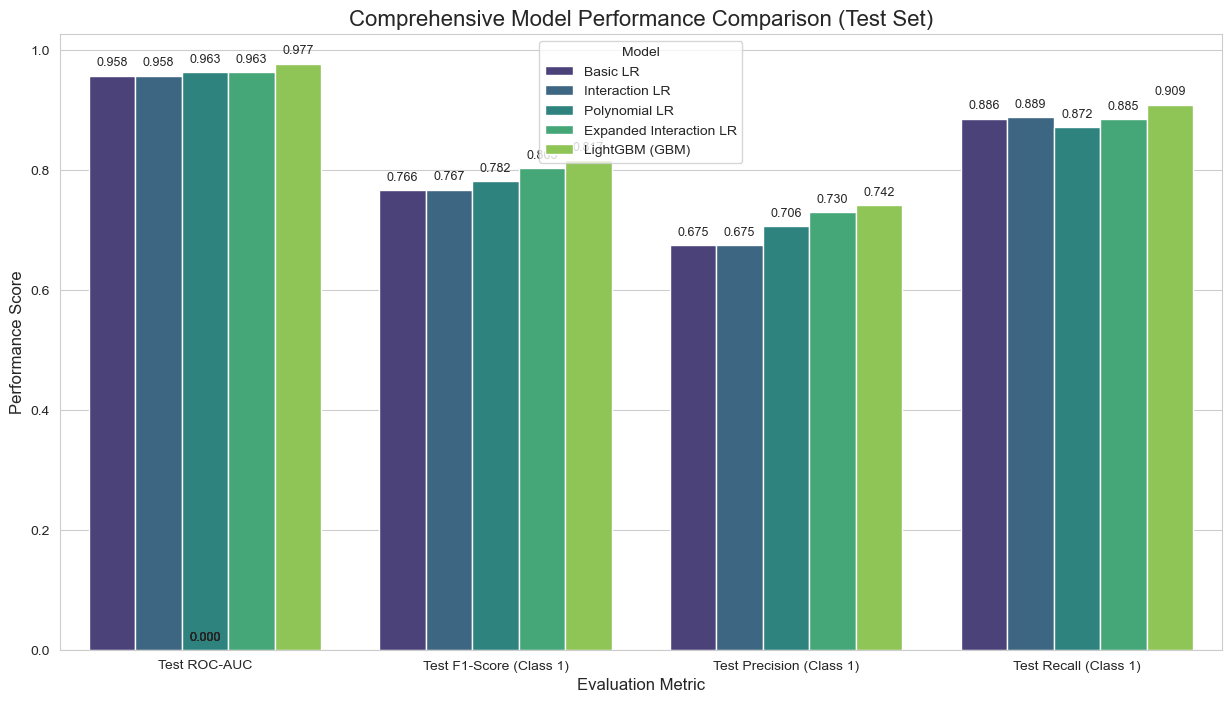

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.image as mpimg

# --- 1. Define the final aggregated performance data (Based on established numerical results) ---
data = {
    "Model": [
        "Basic LR", 
        "Interaction LR", 
        "Polynomial LR", 
        "Expanded Interaction LR", 
        "LightGBM (GBM)"
    ],
    # Final confirmed numerical results for all five models
    "Test ROC-AUC": [0.9576, 0.9575, 0.9632, 0.9631, 0.9774],
    "Test F1-Score (Class 1)": [0.7661, 0.7673, 0.7816, 0.8033, 0.8168],
    "Test Precision (Class 1)": [0.6748, 0.6751, 0.7061, 0.7303, 0.7415],
    "Test Recall (Class 1)": [0.8859, 0.8887, 0.8716, 0.8846, 0.9092]
}

results_df = pd.DataFrame(data)

# --- 2. Convert to long format for plotting ---
results_long = results_df.melt(
    id_vars="Model", 
    var_name="Metric", 
    value_name="Score"
)

# --- 3. Create the Visualization ---
# Define plot order
model_order = [
    "Basic LR", 
    "Interaction LR", 
    "Polynomial LR", 
    "Expanded Interaction LR", 
    "LightGBM (GBM)"
]
metric_order = [
    "Test ROC-AUC", 
    "Test F1-Score (Class 1)", 
    "Test Precision (Class 1)", 
    "Test Recall (Class 1)"
]

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Create the grouped bar chart
bar_plot = sns.barplot(
    data=results_long,
    x="Metric",
    y="Score",
    hue="Model",
    hue_order=model_order,
    order=metric_order,
    palette="viridis" 
)

# Add numerical labels to the bars
for p in bar_plot.patches:
    bar_plot.annotate(
        format(p.get_height(), '.3f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, 9), 
        textcoords = 'offset points',
        fontsize=9
    )

# Customize plot appearance
plt.title("Comprehensive Model Performance Comparison (Test Set)", fontsize=16)
plt.ylabel("Performance Score", fontsize=12)
plt.xlabel("Evaluation Metric", fontsize=12)
plt